In [57]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from definitions import ROOT_DIR


In [115]:
results_dir = Path(ROOT_DIR, 'results', 'final_analytical')
# results_dir = Path(ROOT_DIR, 'results', 'prisoners_dilemma')
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_dm')
vi_results_dir = Path(ROOT_DIR, 'results', 'vi')
pomdp_files_dir = Path(ROOT_DIR, 'grl', 'environment', 'pomdp_files')

args_to_keep = ['spec', 'n_mem_states', 'seed']
split_by = [arg for arg in args_to_keep if arg != 'seed']

# this option allows us to compare to either the optimal belief state soln
# or optimal state soln. ('belief' | 'state')
compare_to = 'belief'

# spec_plot_order = [
#     'example_7', 'tmaze_5_two_thirds_up', 'tiger-alt-start', 'paint.95', 'cheese.95', 'network',
#     'shuttle.95', '4x3.95', 'hallway'
# ]
spec_plot_order = [
   'hallway', 'network', 'paint.95', '4x3.95', 'tiger-alt-start', 'shuttle.95', 'cheese.95', 'tmaze_5_two_thirds_up'
]

# game_name = 'prisoners_dilemma'
# # leader_policies = ['all_d', 'extort', 'tit_for_tat', 'treasure_hunt', 'sugar', 'all_c', 'grudger2', 'alternator', 'majority3']

# leader_policies = ['all_d', 'extort', 'tit_for_tat', 'treasure_hunt', 'sugar', 'grudger2', 'alternator', 'majority3']
# leader_policy_labels = {
#     'all_d': 'all d', 
#     'extort': 'extort', 
#     'tit_for_tat': 'tit for\ntat',
#     'treasure_hunt': 'treasure\nhunt',
#     'sugar':'sugar', 
#     'all_c': 'all c', 
#     'grudger2': 'grudger 2', 
#     'alternator':'alternator', 
#     'majority3':'majority 3'
# }

# spec_plot_order = []
# prisoners_spec_map = {}
# for leader in leader_policies:
#     spec_id = f'{game_name}_{leader}'
#     prisoners_spec_map[spec_id] = leader_policy_labels[leader]
#     spec_plot_order.append(spec_id)

spec_to_belief_state = {'tmaze_5_two_thirds_up': 'tmaze5'}



In [116]:
compare_to_dict = {}

for spec in spec_plot_order:
    if compare_to == 'belief':

        for fname in pomdp_files_dir.iterdir():
            if 'pomdp-solver-results' in fname.stem:
                if (fname.stem ==
                        f"{spec_to_belief_state.get(spec, spec)}-pomdp-solver-results"
                    ):
                    belief_info = load_info(fname)
                    coeffs = belief_info['coeffs']
                    max_start_vals = coeffs[belief_info['max_start_idx']]
                    compare_to_dict[spec] = np.dot(max_start_vals, belief_info['p0'])
                    break
                    # print(f"loaded results for {hparams.spec} from {fname}")
        else:
            for vi_path in vi_results_dir.iterdir():
                for spec in spec_plot_order:
                    if spec_to_belief_state.get(spec, spec) in vi_path.name:
                        vi_info = load_info(vi_path)
                        max_start_vals = vi_info['optimal_vs']
                        compare_to_dict[spec] = np.dot(max_start_vals, vi_info['p0'])
                        
    elif compare_to == 'state':
        for vi_path in vi_results_dir.iterdir():
            if spec_to_belief_state.get(spec, spec) in vi_path.name:
                vi_info = load_info(vi_path)
                max_start_vals = vi_info['optimal_vs']
                compare_to_dict[spec] = np.dot(max_start_vals, vi_info['p0'])
                
#                 compare_to_list.append(spec_compare_indv)


In [117]:
compare_to_dict


{'hallway': 1.5357724175997975,
 'network': 293.18528731501624,
 'paint.95': 3.293597084371071,
 '4x3.95': 1.8834177056359047,
 'tiger-alt-start': 3.7701893248807115,
 'shuttle.95': 32.88972468934434,
 'cheese.95': 3.486206824190127,
 'tmaze_5_two_thirds_up': 1.9131876000000005}

In [119]:
all_results = []

for results_path in results_dir.iterdir():
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue

    info = load_info(results_path)

    args = info['args']
    if args['spec'] not in spec_plot_order:
        continue

    # agent = info['agent']
    init_policy_info = info['logs']['initial_policy_stats']
    init_improvement_info = info['logs']['greedy_initial_improvement_stats']
    final_mem_info = info['logs']['greedy_final_mem_stats']

    def get_perf(info: dict):
        return (info['state_vals_v'] * info['p0']).sum()
    single_res = {k: args[k] for k in args_to_keep}

    final_mem_perf = get_perf(final_mem_info)
    compare_to_perf = compare_to_dict[args['spec']]
    init_policy_perf = get_perf(init_policy_info)
    init_improvement_perf = get_perf(init_improvement_info)
#     if (final_mem_perf > compare_to_perf):
#         if np.isclose(final_mem_perf, compare_to_perf):
#             final_mem_perf = compare_to_perf
#         else:
#             raise Exception(f"{args['spec']}, compare_to_perf: {compare_to_perf:.3f}, final_mem_perf: {final_mem_perf:.3f}")
    
    if init_policy_perf > init_improvement_perf:
        init_policy_perf = init_improvement_perf
    
    single_res.update({
        'init_policy_perf': init_policy_perf,
        'init_improvement_perf': init_improvement_perf,
        'final_mem_perf': final_mem_perf,
        'compare_to_perf': compare_to_perf,
        # 'init_policy': info['logs']['initial_policy'],
        # 'init_improvement_policy': info['logs']['initial_improvement_policy'],
        # 'final_mem': np.array(agent.memory),
        # 'final_policy': np.array(agent.policy)
    })
    all_results.append(single_res)


all_res_df = pd.DataFrame(all_results)

In [120]:
all_res_groups = all_res_df.groupby(split_by, as_index=False)
all_res_means = all_res_groups.mean()
del all_res_means['seed']
all_res_means.to_csv(Path(ROOT_DIR, 'results', 'all_pomdps_means.csv'))

In [121]:
cols_to_normalize = ['init_improvement_perf', 'final_mem_perf']
# merged_df = all_res_df.merge(compare_to_df, on='spec')
merged_df = all_res_df

# for col_name in cols_to_normalize:

normalized_df = merged_df.copy()
normalized_df['init_improvement_perf'] = (normalized_df['init_improvement_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_to_perf'] - merged_df['init_policy_perf'])
normalized_df['final_mem_perf'] = (normalized_df['final_mem_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_to_perf'] - merged_df['init_policy_perf'])
del normalized_df['init_policy_perf']
del normalized_df['compare_to_perf']

In [122]:
normalized_df.loc[(normalized_df['spec'] == 'hallway') & (normalized_df['n_mem_states'] == 8), 'final_mem_perf'] = 0


In [123]:
# normalized_df[normalized_df['spec'] == 'prisoners_dilemma_all_c']
seeds = normalized_df[normalized_df['spec'] == 'tmaze_5_two_thirds_up']['seed'].unique()

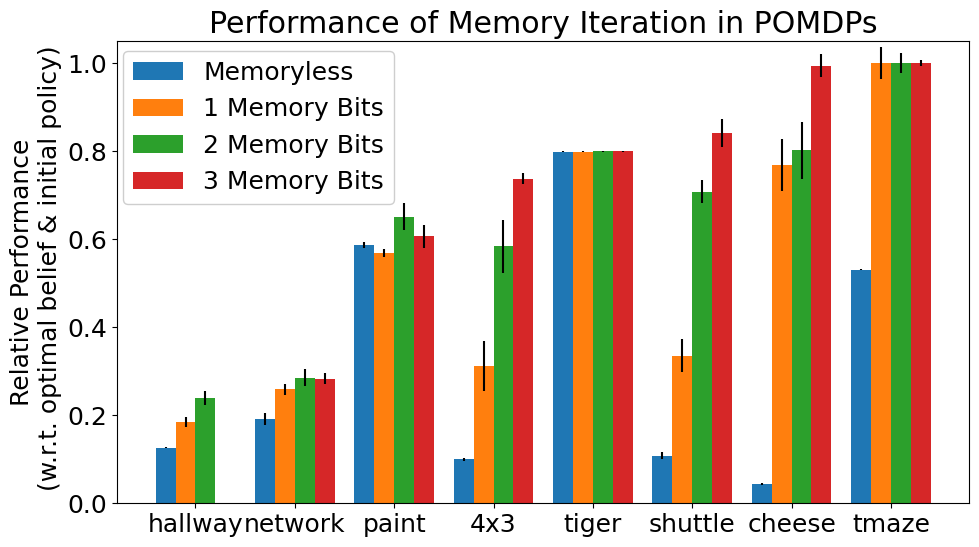

In [149]:
def maybe_spec_map(id: str):
    spec_map = {
        '4x3.95': '4x3',
        'cheese.95': 'cheese',
        'paint.95': 'paint',
        'shuttle.95': 'shuttle',
        'example_7': 'ex. 7',
        'tmaze_5_two_thirds_up': 'tmaze',
        'tiger-alt-start': 'tiger'
    }
    
#     spec_map |= prisoners_spec_map
    
    if id not in spec_map:
        return id
    return spec_map[id]

groups = normalized_df.groupby(split_by, as_index=False)
means = groups.mean()
means['init_improvement_perf'].clip(lower=0, upper=1, inplace=True)
means['final_mem_perf'].clip(lower=0, upper=1, inplace=True)

std_errs = groups.std()
std_errs['init_improvement_perf'] /= np.sqrt(len(seeds))
std_errs['final_mem_perf'] /= np.sqrt(len(seeds))

# SORTING
sorted_mean_df = pd.DataFrame()
sorted_std_err_df = pd.DataFrame()

for spec in spec_plot_order:
    mean_spec_df = means[means['spec'] == spec]
    std_err_spec_df = std_errs[std_errs['spec'] == spec]
    sorted_mean_df = pd.concat([sorted_mean_df, mean_spec_df])
    sorted_std_err_df = pd.concat([sorted_std_err_df, std_err_spec_df])
means = sorted_mean_df
std_errs = sorted_std_err_df
    
num_n_mem = list(sorted(normalized_df['n_mem_states'].unique()))

group_width = 1
bar_width = group_width / (len(num_n_mem) + 2)
fig, ax = plt.subplots(figsize=(11, 6))

specs = means[means['n_mem_states'] == num_n_mem[0]]['spec']
# spec_order_mapping = [spec_plot_order.index(s) for s in specs]
spec_order_mapping = np.arange(len(specs), dtype=int)

xlabels = [maybe_spec_map(l) for l in specs]
x = np.arange(len(specs))

init_improvement_perf_mean = np.array(means[means['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])
init_improvement_perf_std = np.array(std_errs[std_errs['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])

ax.bar(x + (0 + 1) * bar_width,
       init_improvement_perf_mean,
       bar_width,
       yerr=init_improvement_perf_std,
       label='Memoryless')

for i, n_mem_states in enumerate(num_n_mem):
    curr_mem_mean = np.array(means[means['n_mem_states'] == n_mem_states]['final_mem_perf'])
    curr_mem_std = np.array(std_errs[std_errs['n_mem_states'] == n_mem_states]['final_mem_perf'])
    ax.bar(x + (i + 2) * bar_width,
           curr_mem_mean,
           bar_width,
           yerr=curr_mem_std,
           label=f"{int(np.log2(n_mem_states))} Memory Bits")

ax.set_ylim([0, 1.05])
ax.set_ylabel(f'Relative Performance\n (w.r.t. optimal {compare_to} & initial policy)')
ax.set_xticks(x + group_width / 2)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(0.34, 0.62), framealpha=0.95)
ax.set_title("Performance of Memory Iteration in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}.pdf"
fig.savefig(fig_path, bbox_inches='tight')

,spec,n_mem_states,seed,init_improvement_perf,final_mem_perf
0,4x3.95,2,2034.500000,0.100203,0.311344
3,cheese.95,2,2034.500000,0.044184,0.768826
6,example_7,2,2034.500000,0.597204,0.999989
9,hallway,2,2034.500000,0.126740,0.185164
12,network,2,2034.782609,0.191863,0.259360
15,paint.95,2,2034.500000,0.586568,0.568712
18,shuttle.95,2,2034.500000,0.108439,0.335602
21,tiger-alt-start,2,2034.500000,0.798554,0.798554
24,tmaze_5_two_thirds_up,2,2034.500000,0.530688,1.000000


In [85]:
sorted_std_err_df

,spec,n_mem_states,seed,init_improvement_perf,final_mem_perf
6,example_7,2,8.803408,0.007740,2.161539e-07
7,example_7,4,8.803408,0.004380,2.151883e-07
8,example_7,8,8.803408,0.006776,3.838116e-07
24,tmaze_5_two_thirds_up,2,8.803408,0.001495,3.652565e-02
25,tmaze_5_two_thirds_up,4,8.803408,0.001400,2.273279e-02
26,tmaze_5_two_thirds_up,8,8.803408,0.001265,7.007966e-03
21,tiger-alt-start,2,8.803408,0.001157,1.156727e-03
22,tiger-alt-start,4,8.803408,0.000932,9.321115e-04
23,tiger-alt-start,8,8.803408,0.001231,1.231334e-03
15,paint.95,2,8.803408,0.006238,8.413126e-03
